In [42]:
import pandas as pd
import numpy as np
import datetime
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import USFederalHolidayCalendar

# Primary Questions for this Notebook

1. generate a avg rate for each station based on week day traffic

2. generate a pre-quarantine rate and a post quarantine rate

3. calculate the difference between them and see which stations had the least amount of change

4. compare busiest stations pre/post and lowest change in stations pre/post

In [4]:
timeseries = pd.read_csv("../data/output/mta_timeseries.csv")

In [9]:
timeseries.datetime = pd.to_datetime(timeseries.datetime)

In [13]:
overallDailyStats = timeseries.set_index("datetime")

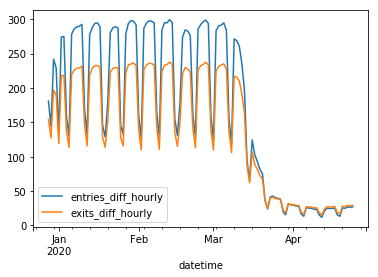

In [16]:
# view rolled up daily stats across the whole system
overallDailyStats.resample("1D").mean().plot()

In [57]:
# determine inflection point
threshold_date = pd.to_datetime("03/15/2020")

In [54]:
# specify business days plus US federal holidays
customBDays = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [55]:
# filter out only working week days
only_business_days = timeseries[timeseries['datetime'].map(customBDays.onOffset)]

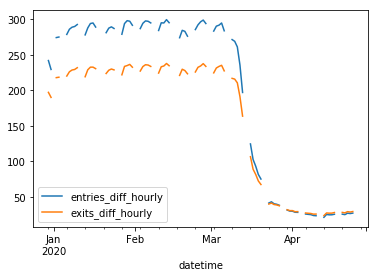

In [56]:
# see overall stats for only business days
only_business_days.set_index("datetime").resample("1D").mean().plot()

In [91]:
# calc averate hourly rates before and after threshold date
def calcPrePostAvgs(gr):
    pre_avg_entries = gr[gr.datetime < threshold_date].entries_diff_hourly.mean()
    pre_avg_exits = gr[gr.datetime < threshold_date].exits_diff_hourly.mean()
    post_avg_entries = gr[gr.datetime > threshold_date].entries_diff_hourly.mean()
    post_avg_exits = gr[gr.datetime > threshold_date].exits_diff_hourly.mean()
    if (pre_avg_entries > 0 ) & (pre_avg_exits > 0):
        pct_diff_entries = (post_avg_entries - pre_avg_entries)/ pre_avg_entries
        pct_diff_exits = (post_avg_exits - pre_avg_exits)/ pre_avg_exits
    else: 
        pct_diff_entries = 0
        pct_diff_exits = 0
    return pd.Series(
        data = [pre_avg_entries, pre_avg_exits, post_avg_entries, post_avg_exits,pct_diff_entries, pct_diff_exits], 
        index = ["pre_avg_hrly_entries", 
        "pre_avg_hrly_exits", 
        "post_avg_hrly_entries", 
        "post_avg_hrly_exits",
        "pct_diff_entries", 
        "pct_diff_exits"
        ])

In [85]:
# for each station calculate pre and post average rates
stationStats = only_business_days.groupby(['station_code', "line_name"]).apply(calcPrePostAvgs)

In [90]:
stationStats.pct_diff_entries.describe()

count    748.000000
mean       0.087818
std       25.331822
min       -1.000000
25%       -0.907559
50%       -0.849582
75%       -0.789482
max      691.970711
Name: pct_diff_entries, dtype: float64

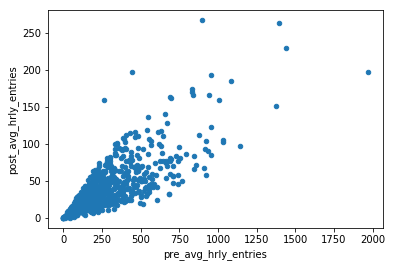

In [94]:
stationStats.plot(kind="scatter", x="pre_avg_hrly_entries", y="post_avg_hrly_entries")